In [ ]:
import os
import numpy as np

# train path
train_images_path = 'train-images-idx3-ubyte.gz'
train_labels_path = 'train-labels-idx1-ubyte.gz'

In [2]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):

    # read data
    import gzip # to decompress gz (zip) file
    # open file training to read training data
    f_images = gzip.open(images_path,'r')

    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)

    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)

    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)

    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)

    labels = np.zeros((real_num)).astype(np.int64)

    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)

        images = images[rand_id, :]
        labels = labels[rand_id,]

    
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [3]:
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)

#print(train_images[1])

Đưa dữ liệu về dạng ảnh 10x10 pixels (giảm số chiều xuống còn 100 chiều bằng phương
pháp phân tích thành phần chính PCA - gộp chung dữ liệu – cả train và validation – sau
đó mới giảm số chiều).

In [4]:
from sklearn.decomposition import PCA

# Áp dụng giảm số chiều PCA
pca = PCA(n_components=100)
data_pca = pca.fit_transform(train_images)
print(data_pca.shape)


(5000, 100)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_pca, train_labels, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)

(3500, 100)
(3500,)


Mô hình ANN

In [6]:
def softmax(V):
    e_V = np.exp(V - np.max(V, axis = 0, keepdims = True))
    Z = e_V / e_V.sum(axis = 0)
    return Z

In [7]:
# cost or loss function

def cost(Y, Yhat):
    return -np.sum(Y*np.log(Yhat))/Y.shape[1]

In [8]:
## One-hot coding
from scipy import sparse
def convert_labels(y, C):
    Y = sparse.coo_matrix((np.ones_like(y),
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

In [9]:
def ANN(X_train, Y_train, eta, max_count):
    X, Y = X_train, Y_train
    d0, N = X_train.shape # d0 is size of input layer
    d1 = h = 200 # size of hidden layer
    d2 = C = Y_train.shape[0] # size of output layer
    
    # initialize parameters randomly
    W1 = 0.01*np.random.randn(d0, d1)
    b1 = np.zeros((d1, 1))
    W2 = 0.01*np.random.randn(d1, d2)
    b2 = np.zeros((d2, 1))
    
    for i in range(max_count + 1):
        ## Feedforward
        Z1 = np.dot(W1.T, X) + b1
        A1 = np.maximum(Z1, 0) ##Activation function là hàm ReLU: f(s) = max(s,0)
                                ## f'(s) = 0 nếu s <= 0, ngược lại f'(s) = 1
        Z2 = np.dot(W2.T, A1) + b2
        Yhat = softmax(Z2)
        # print(Yhat.shape)

        # print loss after each 1000 iterations
        if i %100 == 0:
            # compute the loss: average cross-entropy loss
            loss = cost(Y, Yhat)
            print("iter %d, loss: %f" %(i, loss))


        # backpropagation
        E2 = (Yhat - Y)/N
        dW2 = np.dot(A1, E2.T)
        db2 = np.sum(E2, axis = 1, keepdims = True)
        E1 = np.dot(W2, E2)
        E1[Z1 <= 0] = 0 # gradient of ReLU
        dW1 = np.dot(X, E1.T)
        db1 = np.sum(E1, axis = 1, keepdims = True)

        # Gradient Descent update
        W1 += -eta*dW1
        b1 += -eta*db1
        W2 += -eta*dW2
        b2 += -eta*db2
    return W1, b1, W2, b2

In [14]:
def predict(W1, b1, W2, b2, X):
    Z1 = np.dot(W1.T, X) + b1
    A1 = np.maximum(Z1, 0)
    Z2 = np.dot(W2.T, A1) + b2
    a = softmax(Z2)
    
    return np.argmax(a, axis=0)

In [11]:
C = 10
X_train1 = np.array(X_train).T
Y_train = convert_labels(y_train, C)
W1, b1, W2, b2 = ANN(X_train1, Y_train, 1e-3, 1000)

iter 0, loss: 3.384852
iter 100, loss: 0.215554
iter 200, loss: 0.128395
iter 300, loss: 0.086569
iter 400, loss: 0.062541
iter 500, loss: 0.047449
iter 600, loss: 0.037419
iter 700, loss: 0.030356
iter 800, loss: 0.025190
iter 900, loss: 0.021305
iter 1000, loss: 0.018325


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve

X_val1 = np.array(X_val).T
Y_pred_val = predict(W1, b1, W2, b2, X_val1)
print("Accuracy: %.2f %% " % (100*accuracy_score(y_val,Y_pred_val)))

cm = confusion_matrix(y_val,Y_pred_val)

from sklearn.metrics import precision_score, recall_score
precision_micro = precision_score(y_val,Y_pred_val, average='macro')
recall_micro = recall_score(y_val,Y_pred_val, average='macro')
print('Precision: %.2f %%' % (100*precision_micro))
print('Recall:  %.2f %%' % (100*recall_micro))

Accuracy: 93.87 % 
Precision: 93.82 %
Recall:  93.78 %


Text(0.5, 1.0, 'ANN ')

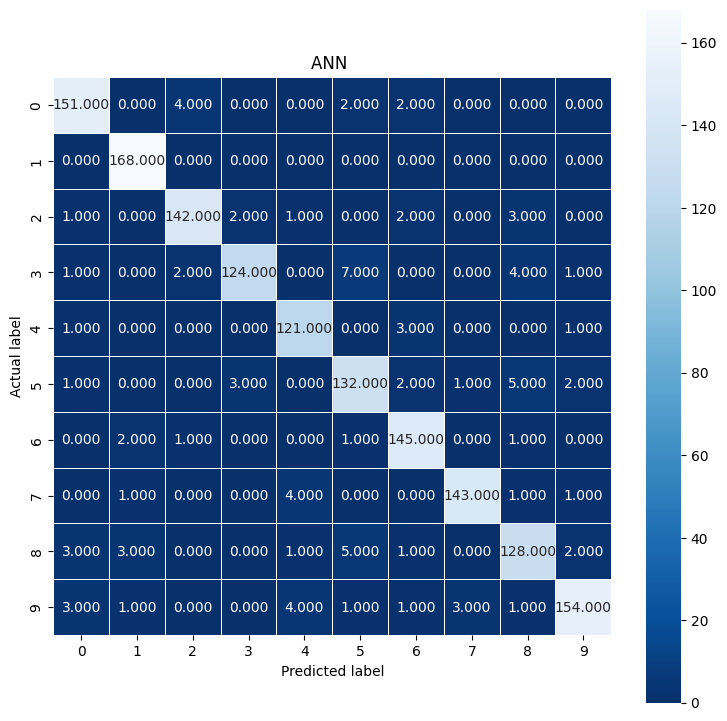

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("ANN ")